# Variational Autoencoder for Augmentation of Laser-Based Laryngeal Imaging

For the deep-learning-based algorithm to match features via a registration task, it is essential to have apply intense data augmentation to the training data set. As displayed in the following figure the training data consists of images $m(x)$ that represent the spatial configuration of laser points projected onto the vocal fold surface.

![alt text here](images/feature_matching_registration.png "Logo Title Jupyter Notebook logo")

The foundation for the images $m(x)$ are the x-y-coordinates of each single laser point within the image, as $m(x)$ is generated by plotting the single laser points and then smoothing the image. To create intense augmentation we want to train a variational autoencoder (VAE) to then generate images that are variations of the images of the training set and represent feasible configurations of laser points projected onto a vocal fold. The implementation of the VAE is inspired by [Keras](https://keras.io/examples/generative/vae/).

In a VAE a decoder-encoder architecture is utilized. The coding is split up into a vector representing the mean $\mu$
of a distribution over a latent space. The distribution is assumed to be gaussian. Therefore, a second vector exists as a coding representing the variance $\mathbf{\sigma^2}$. Behind the coding a sampling layer exists that randomly samples a value from the distribution given by $\mathcal{N}(\mu,\,\sigma^{2})$. Like that it is possible to create a smooth latent space. The network can be trained in a unsupervised manner, as the the decoder should learn to reconstruct the input of the encoder as good as possible. After training, only the decoder part will be used. Inputing random points in the latent space will then generate x- and y-coordinates that are part of the underlying trained distribution based on the ground truth.

## Imports
The notebook was developed on Keras using the Tensorflow 2.2.0 backend.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

## Hardware Configuration
Check for GPU and allow memory growth such that limitations for training are reduced. 

In [2]:
if len(tf.config.experimental.get_visible_devices('GPU')):
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Functionality
The following functionality helps to create the images for training the registration task.

In [3]:
def apply_smoothing(image, sigma=1.0, sigma_back=10.0):
    image_orig = image
    image = gaussian_filter(image, sigma=sigma)
    image_back = gaussian_filter(image, sigma=sigma_back)

    image = (image / image.max()) * 255
    image_back = (image_back / image_back.max()) * 255
    image = 0.3 * image_orig + 0.3 * image + 0.3 * image_back

    return image

In [4]:
def reconstruct_image(x_position, y_position):
    # Unpad
    x_position = x_position[1:-1, 1:-1]
    y_position = y_position[1:-1, 1:-1]
    image = np.zeros((image_height, image_width))
    for x, y in zip(x_position.flatten(), y_position.flatten()):
        x = int(x*image_width)
        y = int(y*image_height)
        
        if x >= 5 and y>= 5:
            image[y][x] = 1
        
    image = apply_smoothing(image, sigma=2, sigma_back=15)
    return image

## Model parameters
The grid dimensions have to be know, as well as the image dimensions for scaling. The amount of input and output layers is 2 here, as we will have one channel representing x-coordinates and a second channel representing y-coordinates. 

In [5]:
grid_width = 18
grid_height = 18

image_width = 728
image_height = 728

inout_layers = 2

## Hyperparameters
The dimension of the latent space can be adapted to optimize the network. 

In [6]:
latent_dim = 6

## Sampling Layer
In the sampling layer the coding $\mathbf{\mu}$ and $\log{(\mathbf{\sigma^2})}$ are used to randomly sample a point from the underlying distribution. Due to this randomness that occurs within each batch and along all epochs the decoder is trained on smooth distributions. Each coding $\mathbf{c}$ used to train the decoder is computed as

$$\mathbf{c} = \mathbf{\mu} + e^{0.5\mathbf{\log{(\mathbf{\sigma^2})}}}\mathbf{\epsilon}$$

where $\epsilon$ is a random vector with entries between 0 and 1.

In [7]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder Model
In the encoder strided convolutional layers are applied to reduce the dimensionality of the input. For a grid with dimension 18x18 the input shape is increased to 20x20 and the input images are padded. Like that it is easier to ensure symmetry between encoder an decoder. The encoder is a keras model having the mean, variance and a sampled value as output.

In [8]:
encoder_inputs = keras.Input(shape=(grid_width+2, grid_height+2, inout_layers))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
#encoder.summary()

## Decoder Model
The decoder takes only a sampeled value or a randomly selected value with the size of the latent space as input. 
Dimnesion of the input of the encoder is the reconstructed. The decoder is constructed as a keras model.

In [9]:
latent_inputs = keras.Input(shape=(latent_dim,))
y_val = (grid_height+2)//4
x_val = (grid_width+2)//4

x = layers.Dense(y_val*x_val*64, activation="relu")(latent_inputs)
x = layers.Reshape((y_val, x_val, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(inout_layers, 3, activation="linear", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
#decoder.summary()

## VAE Model
The VAE is composed by the encoder and decoder. The decoder only takes the random coding $\mathbf{c}$ from the encoder. However, the codings $\mathbf{\mu}$ and $\log{(\mathbf{\sigma^2})}$ are used to compute a loss for regularizing and ensuring a smooth overall distribution. The coding loss is:

$$ \epsilon_{coding} = 1 + \log{(\sigma^2)} - \mu^2 - \sigma^2 $$

A binary crossentropy (!!! We should try linear and mse!!!) is used to define a reconstruction loss $\epsilon_{reconstruction}$. The overall loss is then:

$$\epsilon = \epsilon_{reconstruction} - \epsilon_{coding}$$

In [10]:
class VariationalAutoEncoder(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VariationalAutoEncoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        # Gradient tape allows to "record" a function that will be derived
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            
            # Reconstuction Loss
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
                #keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= grid_height+2 * grid_height+2
            
            # Regularization Loss for well formed latent space and no overfitting
            coding_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            coding_loss = tf.reduce_mean(coding_loss)
            coding_loss *= -0.05
            
            # Total Loss
            total_loss = reconstruction_loss + coding_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "coding_loss": coding_loss,
        }

## Prepare data
Load the data and scale them to be between 0.0 an 1.0. Further use zero-padding to get a 20x20 shape for this example.

In [11]:
x_position = np.load('data/x_pos_LASTEN2.npy')
y_position = np.load('data/y_pos_LASTEN2.npy')

x_position = x_position / image_width
y_position = y_position / image_height

a = x_position

# Zero padding
x_position = np.pad(x_position,[(0,0),(1,1),(1,1)],constant_values=0)
y_position = np.pad(y_position,[(0,0),(1,1),(1,1)],constant_values=0)

x_position = x_position[:,:,:,np.newaxis]
y_position = y_position[:,:,:,np.newaxis]

xy_data = np.concatenate((x_position, y_position), axis=3)
print("Shape of 'xy_data': {}".format(xy_data.shape))

Shape of 'xy_data': (160, 20, 20, 2)


## Training
Initialize the VAE, compile it and fit the model.

In [12]:
vae = VariationalAutoEncoder(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(xy_data, epochs=400, batch_size=10)

Epoch 1/400
16/16 [==============================] - 0s 4ms/step - loss: 5.8871 - reconstruction_loss: 5.8622 - coding_loss: 0.0249 
Epoch 2/400
16/16 [==============================] - 0s 5ms/step - loss: 2.7615 - reconstruction_loss: 2.7518 - coding_loss: 0.0097
Epoch 3/400
16/16 [==============================] - 0s 5ms/step - loss: 2.0262 - reconstruction_loss: 2.0156 - coding_loss: 0.0106
Epoch 4/400
16/16 [==============================] - 0s 5ms/step - loss: 1.5172 - reconstruction_loss: 1.4943 - coding_loss: 0.0229
Epoch 5/400
16/16 [==============================] - 0s 5ms/step - loss: 1.2452 - reconstruction_loss: 1.1960 - coding_loss: 0.0492
Epoch 6/400
16/16 [==============================] - 0s 4ms/step - loss: 1.0461 - reconstruction_loss: 0.9613 - coding_loss: 0.0848
Epoch 7/400
16/16 [==============================] - 0s 5ms/step - loss: 0.8441 - reconstruction_loss: 0.7230 - coding_loss: 0.1212
Epoch 8/400
16/16 [==============================] - 0s 5ms/step - loss: 0.

16/16 [==============================] - 0s 5ms/step - loss: 0.1693 - reconstruction_loss: 0.1005 - coding_loss: 0.0687
Epoch 63/400
16/16 [==============================] - 0s 5ms/step - loss: 0.1715 - reconstruction_loss: 0.1024 - coding_loss: 0.0691
Epoch 64/400
16/16 [==============================] - 0s 5ms/step - loss: 0.1619 - reconstruction_loss: 0.0985 - coding_loss: 0.0634
Epoch 65/400
16/16 [==============================] - 0s 5ms/step - loss: 0.1627 - reconstruction_loss: 0.0916 - coding_loss: 0.0711
Epoch 66/400
16/16 [==============================] - 0s 5ms/step - loss: 0.1518 - reconstruction_loss: 0.0885 - coding_loss: 0.0634
Epoch 67/400
16/16 [==============================] - 0s 5ms/step - loss: 0.1543 - reconstruction_loss: 0.0874 - coding_loss: 0.0669
Epoch 68/400
16/16 [==============================] - 0s 5ms/step - loss: 0.1514 - reconstruction_loss: 0.0848 - coding_loss: 0.0666
Epoch 69/400
16/16 [==============================] - 0s 5ms/step - loss: 0.1504 -

16/16 [==============================] - 0s 5ms/step - loss: 0.1130 - reconstruction_loss: 0.0565 - coding_loss: 0.0565
Epoch 124/400
16/16 [==============================] - 0s 5ms/step - loss: 0.1161 - reconstruction_loss: 0.0543 - coding_loss: 0.0618
Epoch 125/400
16/16 [==============================] - 0s 5ms/step - loss: 0.1082 - reconstruction_loss: 0.0525 - coding_loss: 0.0558
Epoch 126/400
16/16 [==============================] - 0s 5ms/step - loss: 0.1074 - reconstruction_loss: 0.0503 - coding_loss: 0.0571
Epoch 127/400
16/16 [==============================] - 0s 5ms/step - loss: 0.1064 - reconstruction_loss: 0.0476 - coding_loss: 0.0588
Epoch 128/400
16/16 [==============================] - 0s 5ms/step - loss: 0.1114 - reconstruction_loss: 0.0548 - coding_loss: 0.0566
Epoch 129/400
16/16 [==============================] - 0s 5ms/step - loss: 0.1062 - reconstruction_loss: 0.0481 - coding_loss: 0.0582
Epoch 130/400
16/16 [==============================] - 0s 5ms/step - loss: 0

16/16 [==============================] - 0s 5ms/step - loss: 0.0977 - reconstruction_loss: 0.0417 - coding_loss: 0.0560
Epoch 185/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0956 - reconstruction_loss: 0.0409 - coding_loss: 0.0547
Epoch 186/400
16/16 [==============================] - 0s 5ms/step - loss: 0.1002 - reconstruction_loss: 0.0444 - coding_loss: 0.0559
Epoch 187/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0986 - reconstruction_loss: 0.0421 - coding_loss: 0.0566
Epoch 188/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0966 - reconstruction_loss: 0.0441 - coding_loss: 0.0525
Epoch 189/400
16/16 [==============================] - 0s 5ms/step - loss: 0.1042 - reconstruction_loss: 0.0522 - coding_loss: 0.0520
Epoch 190/400
16/16 [==============================] - 0s 4ms/step - loss: 0.0944 - reconstruction_loss: 0.0384 - coding_loss: 0.0560
Epoch 191/400
16/16 [==============================] - 0s 5ms/step - loss: 0

16/16 [==============================] - 0s 5ms/step - loss: 0.0886 - reconstruction_loss: 0.0366 - coding_loss: 0.0520
Epoch 246/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0886 - reconstruction_loss: 0.0345 - coding_loss: 0.0541
Epoch 247/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0916 - reconstruction_loss: 0.0363 - coding_loss: 0.0553
Epoch 248/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0927 - reconstruction_loss: 0.0365 - coding_loss: 0.0562
Epoch 249/400
16/16 [==============================] - 0s 4ms/step - loss: 0.0891 - reconstruction_loss: 0.0373 - coding_loss: 0.0517
Epoch 250/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0965 - reconstruction_loss: 0.0375 - coding_loss: 0.0590
Epoch 251/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0871 - reconstruction_loss: 0.0328 - coding_loss: 0.0543
Epoch 252/400
16/16 [==============================] - 0s 5ms/step - loss: 0

16/16 [==============================] - 0s 5ms/step - loss: 0.0924 - reconstruction_loss: 0.0369 - coding_loss: 0.0555
Epoch 307/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0832 - reconstruction_loss: 0.0285 - coding_loss: 0.0547
Epoch 308/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0788 - reconstruction_loss: 0.0287 - coding_loss: 0.0501
Epoch 309/400
16/16 [==============================] - 0s 4ms/step - loss: 0.0913 - reconstruction_loss: 0.0312 - coding_loss: 0.0601
Epoch 310/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0855 - reconstruction_loss: 0.0310 - coding_loss: 0.0545
Epoch 311/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0861 - reconstruction_loss: 0.0274 - coding_loss: 0.0586
Epoch 312/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0875 - reconstruction_loss: 0.0342 - coding_loss: 0.0533
Epoch 313/400
16/16 [==============================] - 0s 5ms/step - loss: 0

16/16 [==============================] - 0s 5ms/step - loss: 0.0877 - reconstruction_loss: 0.0281 - coding_loss: 0.0596
Epoch 368/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0838 - reconstruction_loss: 0.0292 - coding_loss: 0.0546
Epoch 369/400
16/16 [==============================] - 0s 4ms/step - loss: 0.0907 - reconstruction_loss: 0.0333 - coding_loss: 0.0574
Epoch 370/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0874 - reconstruction_loss: 0.0308 - coding_loss: 0.0566
Epoch 371/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0866 - reconstruction_loss: 0.0288 - coding_loss: 0.0578
Epoch 372/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0878 - reconstruction_loss: 0.0338 - coding_loss: 0.0541
Epoch 373/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0848 - reconstruction_loss: 0.0278 - coding_loss: 0.0570
Epoch 374/400
16/16 [==============================] - 0s 5ms/step - loss: 0

## Reconstruct a ground truth image
Get the mean value for a ground truth image and decode the value to reconstruct the image

In [13]:
res_encoder = encoder.predict(xy_data[:1])[0]
res_decoder = decoder.predict(res_encoder)
x = res_decoder[0,:,:,0]
y = res_decoder[0,:,:,1]
x_orig = xy_data[0,:,:,0]
y_orig = xy_data[0,:,:,1]

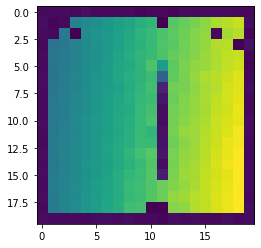

In [14]:
plt.imshow(x)

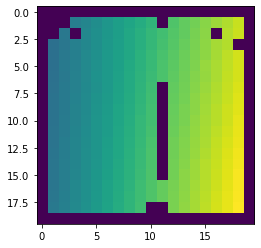

In [15]:
plt.imshow(x_orig)

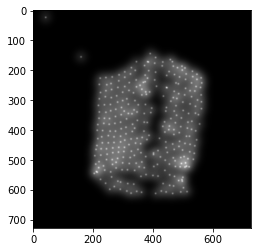

In [16]:
plt.imshow(reconstruct_image(x, y),cmap='gist_gray')

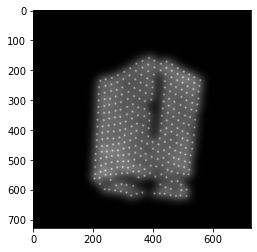

In [17]:
plt.imshow(reconstruct_image(x_orig, y_orig),cmap='gist_gray')

## Generate an image based on a vector from the latent space

In [20]:
%%capture
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, widgets
from IPython.display import display

def f(**sliders):
    sliders_float = [float(slider[1]) for slider in sliders.items()]
    res_encoder = np.array([sliders_float])
    res_decoder = decoder.predict(res_encoder)
    
    x = res_decoder[0,:,:,0]
    y = res_decoder[0,:,:,1]
    
    img = reconstruct_image(x, y)

    ax.imshow(img, cmap="gray")
    fig.canvas.draw()
    display(fig)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes(plt.axes())

sliders = {str(i): widgets.FloatSlider(min=-2.0,max=2.0,step=0.1,value=0.0) for i in range(latent_dim)}

In [22]:
_ = interact(f, **sliders)

interactive(children=(FloatSlider(value=0.0, description='0', max=2.0, min=-2.0), FloatSlider(value=1.8, descr…